In [1]:
!pwd
import sys
sys.path.append("..")
from bumps.names import Curve, fit, FitProblem
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import molgroups as mol


/Users/alyssa/Documents/GitHub/molgroups/Diffraction


some functions

In [2]:
def getSLD(aArea, aSL, dimension, stepsize, normArea, bulksld):
    aSLD = np.zeros(dimension).tolist()
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i] * stepsize) * aArea[i] / normArea + bulksld * (
                1 - aArea[i] / normArea
            )
        else:
            aSLD[i] = bulksld
    return aSLD


In [3]:
def computeFormFactor(lq, aSLD, dimension, stepsize, bulksld, prefactor, dq):
    center = bilayer.fnGetCenter()
    center = center // stepsize
    canvas_center = dimension // 2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1]) * 0.5
    symmetrized_bilayer -= bulksld
    half_bilayer = symmetrized_bilayer[int(dimension / 2) :]

    # TODO: Make sure that lq and x are roughly comparable
    dct_dimension = 5000
    F = fft.dct(half_bilayer, n=dct_dimension)
    F = np.abs(F)
    x = np.array(
        [
            np.pi / (2 * dct_dimension * stepsize) * (2 * i) * dq
            for i in range(dct_dimension)
        ]
    )

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, left=None, right=None, period=None) * prefactor


In [4]:
def setBilayer(startz, l_lipid, sigma, bulksld, rel_pos, hg_thickness, methyl_sigma):
    bilayer.headgroup1.fnSet(hg_thickness, rel_pos)
    bilayer.headgroup2.fnSet(hg_thickness, rel_pos)
    bilayer.methyl_sigma = methyl_sigma
    bilayer.fnSet(sigma, bulksld, startz, l_lipid, l_lipid, vf_bilayer=1)


In [5]:
def modelformfactor(
    lq, l_lipid, sigma, bulksld, prefactor, dq, rel_pos, hg_thickness, methyl_sigma
):
    setBilayer(startz, l_lipid, sigma, bulksld, rel_pos, hg_thickness, methyl_sigma)
    z = np.linspace(0, dimension * stepsize, dimension, endpoint=False)
    normArea, aArea, aSL = bilayer.fnWriteProfile(z)
    aSLD = getSLD(aArea, aSL, dimension, stepsize, normArea, bulksld)
    modelform = computeFormFactor(lq, aSLD, dimension, stepsize, bulksld, prefactor, dq)
    problem.extra = bilayer
    problem.stepsize = stepsize
    problem.dimension = dimension
    return modelform


Global Variables

In [6]:
maxarea = 100
stepsize = 0.5
dimension = 300
startz = 50


Load Experimental Data

In [7]:
ULV = np.loadtxt("exp_data/dopcULV.dat")
MLV = np.loadtxt("exp_data/dopcMLVs.dat")
ORI = np.loadtxt("exp_data/dopcOri.dat")
F2 = np.concatenate((ULV, MLV, ORI))
F2 = F2[np.argsort(F2[:, 0])]
q_exp = F2[:, 0]
form_exp = F2[:, 1]
# constant error bar estimate of .05 Å
dform_exp = [0.05] * len(form_exp)


Set scattering lengths, volumes, lengths
| abb | name |
| :- | :- |
|va1 |Volume acyl chains, lipid 1|
|na1 |SL acyl chains, lipid 1|
|vm1 |Volume methyl groups, lipid 1|
|nm1 |SL methyl groups, lipid 1|
|vh1 |Headgroup volume, lipid 1|
|nh1 |SL headgroup, lipid 1|
|lh1 |Length headgroup, lipid 1|
|va2 |Volume acyl chains, lipid 2|
|na2 |SL acyl chains, lipid 2|
|vm2 |Volume methyl groups, lipid 2|
|nm2 |SL methyl groups, lipid 2|
|vh2 |Headgroup volume, lipid 2|
|nh2 |SL headgroup, lipid 2|
|lh2 |Length headgroup, lipid 2|
|va3 |Volume acyl chains, lipid 3|
|na3 |SL acyl chains, lipid 3|
|vm3 |Volume methyl groups, lipid 3|
|nm3 |SL methyl groups, lipid 3|
|vh3 |Headgroup volume, lipid 3|
|nh3 |SL headgroup, lipid 3|
|lh3 |Length headgroup, lipid 3|
|vc  |volume cholesterol|
|nc  |SL cholesterol|


In [8]:
bilayer = mol.BLM_quaternary()
na1, nh1, nm1, va1, vm1, vh1, lh1 = (
    7.5978e-03,
    4.6150e-03,
    5.0652e-04,
    972.00,
    98,
    331.00,
    9.56,
)
bilayer.fnInit(va1, na1, vm1, nm1, vh1, nh1, lh1)


In [9]:
l_lipid = 11.6
sigma = 2.0
bulksld = 9.4114e-06
prefactor = 15000
dq = 1.0
rel_pos = 0.5
methyl_sigma = 2


In [10]:
M1 = Curve(
    modelformfactor,
    q_exp,
    form_exp,
    dform_exp,
    l_lipid=l_lipid,
    sigma=sigma,
    bulksld=bulksld,
    prefactor=prefactor,
    dq=dq,
    rel_pos=rel_pos,
    hg_thickness=lh1,
    methyl_sigma=methyl_sigma,
)


In [11]:
M1.l_lipid.range(9, 13)
M1.sigma.range(2.0, 4.0)
M1.bulksld.range(9e-6, 10e-6)
M1.prefactor.range(5000, 30000)
M1.dq.range(0.95, 1.05)
M1.hg_thickness.range(8, 12)
M1.rel_pos.range(0, 1)
M1.methyl_sigma.range(0, 4)


Parameter(methyl_sigma)

In [12]:
model = M1
problem = FitProblem(model)


In [13]:
result = fit(
    problem,
    method="dream",
    samples=10,
    burn=20,
    steps=20,
    thin=1,
    alpha=0,
    outliers="none",
    trim="none",
)


# steps: 20, # draws: 1600
Did not converge!


In [14]:
store = 'T2'
if not os.path.isdir(store): 
    os.mkdir(store)

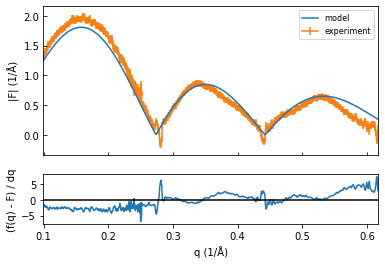

In [15]:
import plot
result.state.save(store + "/run")
problem.fitness.save(store + "/run")
plot.graphBumpsResults(store + "/run.dat")


In [16]:
from bumps.dream.stats import var_stats, format_vars, save_vars

print("final chisq", problem.chisq_str())
draw = result.state.draw(portion=1)
all_vstats = var_stats(draw)
print(format_vars(all_vstats))
save_vars(all_vstats, store + "/run")


final chisq 6.097(16)
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1              bulksld 9.46(14)e-6 0.000009416 0.000009414 [0.00000939 0.00000958] [0.00000917 0.00000985]
 2                   dq  1.003(15)  0.9999  1.0346 [  0.993   1.016] [  0.976   1.045]
 3         hg_thickness   9.61(58)   9.560   9.961 [   9.23   10.03] [   8.14   11.00]
 4              l_lipid  12.06(44)  11.908  12.673 [  11.60   12.64] [  11.60   12.91]
 5         methyl_sigma   1.85(45)   2.000   0.221 [   1.65    2.04] [   0.38    2.37]
 6            prefactor  15001(19) 15000.09 14989.35 [14994.1 15009.2] [14967.7 15042.5]
 7              rel_pos   0.52(21)   0.500   0.006 [   0.36    0.72] [   0.05    0.95]
 8                sigma  2.017(37)   2.004   2.009 [   2.00    2.03] [   2.00    2.14]


/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-packages/bumps/dream/varplot.py:240: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolormesh(x, y, z, vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-packages/bumps/dream/varplot.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers, height, maxlikelihood = array(bins).T
/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-packages/bumps/dream/varplot.py:240: Matp

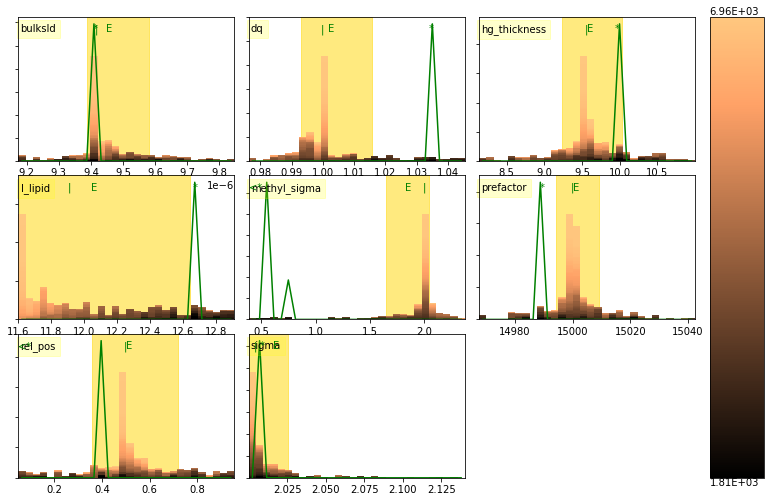

In [17]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig, suptitle, rcParams

figure(figsize=varplot.var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0] // 10000, 400), 30)
varplot.plot_vars(draw, all_vstats, nbins=nbins)
savefig(store + "/var")


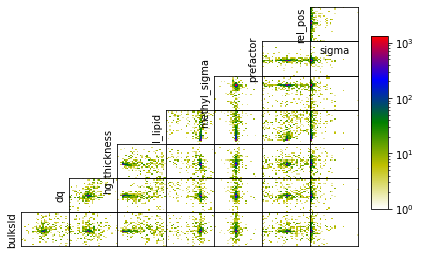

In [18]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()
savefig(store + "/corr")


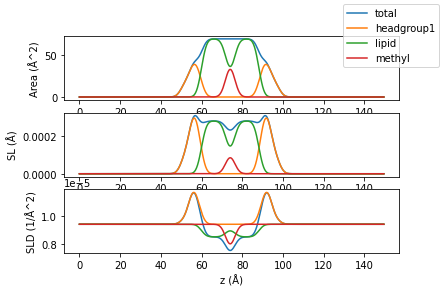

In [20]:
import plot

bulksld, dq, hg_thickness, l_lipid, methyl_sigma, prefactor, rel_pos, sigma = result.x
setBilayer(startz, l_lipid, sigma, bulksld, rel_pos, hg_thickness, methyl_sigma)
plot.graphProfiles(
    bilayer, dimension, stepsize, maxarea, bulksld, show=True, savefile=None
)


In [21]:
p = result.state.best()[0]
problem.setp(p)
print(problem.chisq())


6.097244210604915


In [22]:
sys.path.append(os.pardir + '/PlottingAndAnalysis') #TODO implement packages?
import rs
import os

setupdir = os.getcwd()
mcmcstor = store
runfile = "run"
fitsource = "bumps"

if os.path.isfile(mcmcstor + "/sErr.dat"):
    os.remove(mcmcstor + "/sErr.dat")
if os.path.isfile(mcmcstor + "/isErr.dat"):
    os.remove(mcmcstor + "/isErr.dat")
if os.path.isfile(mcmcstor + "/StatDataPython.dat"):
    os.remove(mcmcstor + "/StatDataPython.dat")

fit_analysis = rs.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=mcmcstor,
    runfile=runfile,
    state=result.state,
    problem=problem,
)


In [23]:
sparse = 0.002
fit_analysis.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)


Analysis of current MC simulation ...
Number of iterations: 4
     bulksld  [    + |    ]  [     9e-06,     1e-05]  [ 9.375e-06(0.000),  9.409e-06(0.000),  9.636e-06(0.000)] (- 3.319e-08, + 2.274e-07)
          dq  [     | - | ]  [      0.95,      1.05]  [    0.9999(0.000),      1.015(0.000),      1.038(0.000)] (-   0.01545, +   0.02315)
hg_thickness  [    +|     ]  [         8,        12]  [     9.404(0.000),      9.563(0.000),      9.809(0.000)] (-    0.1592, +    0.2461)
     l_lipid  [       |-| ]  [         9,        13]  [     11.69(0.000),      12.06(0.000),      12.64(0.000)] (-    0.3651, +    0.5849)
methyl_sigma  [    |+     ]  [         0,         4]  [      1.52(0.000),      1.982(0.000),      2.099(0.000)] (-    0.4615, +    0.1169)
   prefactor  [    +      ]  [      5000,     3e+04]  [ 1.499e+04(0.000),    1.5e+04(0.000),  1.502e+04(0.000)] (-     9.074, +     23.58)
     rel_pos  [ | - |     ]  [         0,         1]  [   0.08802(0.000),     0.3249(0.000),     0.5243(

In [24]:
fit_analysis.fnPullMolgroup(["lipid1"], sparse=sparse)


Failure to load StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Processing parameter set 0.

23.45715175449251
Processing parameter set 1.

19.0822234637184
Processing parameter set 2.

6.239890361192788
Processing parameter set 3.

10.832736830133308


In [25]:
fit_analysis.fnCreateBilayerPlotData()


Initializing ...
Pulling all molgroups ...
  substrate ...
Loaded statistical data from StatDataPython.dat
Molecular group substrate does not exist.
  siox ...
Loaded statistical data from StatDataPython.dat
Molecular group siox does not exist.
  tether ...
Loaded statistical data from StatDataPython.dat
Molecular group bME does not exist.
Molecular group tetherg does not exist.
Molecular group tether does not exist.
  innerhg ...
Loaded statistical data from StatDataPython.dat
  innerhc ...
Loaded statistical data from StatDataPython.dat
  outerhc ...
Loaded statistical data from StatDataPython.dat
  outerhg ...
Loaded statistical data from StatDataPython.dat
  protein ...
Loaded statistical data from StatDataPython.dat
Molecular group protein does not exist.
Applying corrections ...

Calculating statistics ...



/Users/alyssa/Documents/GitHub/molgroups/Diffraction/../PlottingAndAnalysis/rs.py:1731: RuntimeWarning: invalid value encountered in true_divide
  diIterations[element + '_cvo'][key] = diIterations[element][key] / areaperlipid
/Users/alyssa/Documents/GitHub/molgroups/Diffraction/../PlottingAndAnalysis/rs.py:1732: RuntimeWarning: invalid value encountered in true_divide
  diIterations[element + '_corr_cvo'][key] = diIterations[element + '_corr'][key] / areaperlipid
/Users/alyssa/Documents/GitHub/molgroups/Diffraction/../PlottingAndAnalysis/rs.py:1731: RuntimeWarning: divide by zero encountered in true_divide
  diIterations[element + '_cvo'][key] = diIterations[element][key] / areaperlipid
/Users/alyssa/Documents/GitHub/molgroups/Diffraction/../PlottingAndAnalysis/rs.py:1732: RuntimeWarning: divide by zero encountered in true_divide
  diIterations[element + '_corr_cvo'][key] = diIterations[element + '_corr'][key] / areaperlipid
/Users/alyssa/opt/anaconda3/envs/fitting/lib/python3.8/site-

Saving data to bilayerplotdata.dat ...



In [26]:
fit_analysis.fnCalculateMolgroupProperty(fConfidence=-1)


Loaded statistical data from StatDataPython.dat
Did not find any fractional envelopes ...
WaterFracHeadgroup1  [    0.5173,     0.5392,     0.5513] (-   0.02183, +   0.01215)
WaterFracHeadgroup2  [    0.4917,      0.516,     0.5247] (-   0.02427, +  0.008725)
WaterFracHydrocarbon  [   0.02557,    0.02889,    0.03111] (-  0.003323, +  0.002219)
WaterFracLipid1  [   0.02847,    0.03213,    0.03499] (-  0.003662, +  0.002858)
WaterFracLipid2  [   0.02267,    0.02573,     0.0273] (-  0.003056, +  0.001577)
WaterFracSubMembrane  [    0.9961,     0.9963,     0.9965] (- 0.0002612, + 0.0001582)
defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
defect_hc_INT  [         0,          0,          0] (-         0, +         0)
defect_hg_AVG  [         0,          0,          0] (-         0, +         0)
defect_hg_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
defect_hg_I

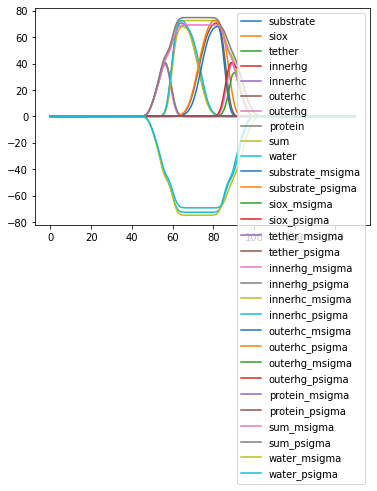

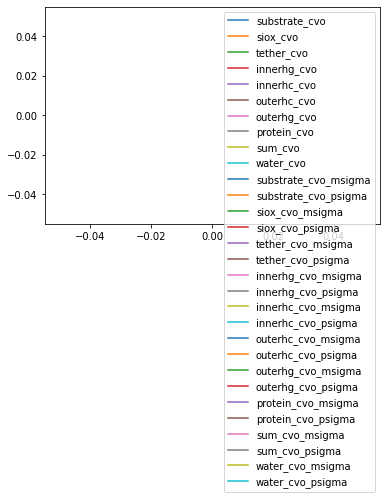

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

bilayer_plot_data = pd.read_csv(store +"/bilayerplotdata.dat", sep="\s", engine="python")
area = []
cvo = []
for elem in bilayer_plot_data.keys():
    if "corr" in elem or "zaxis" in elem:
        continue
    if "cvo" in elem:
        cvo.append(elem)
        continue
    area.append(elem)

for i, elem in enumerate(area):
    plt.plot(bilayer_plot_data["zaxis"], bilayer_plot_data[elem], label=elem)
plt.legend()
plt.show()
for i, elem in enumerate(cvo):
    plt.plot(bilayer_plot_data["zaxis"], bilayer_plot_data[elem], label=elem)
plt.legend()
plt.show()
